In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

import kagglehub
import tensorflow as tf
import keras as kb

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation

Downloading image dataset from kaggle

In [6]:
# code provided by kaggle 
# path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")
# print("Path to dataset files:", path)

100%|██████████| 1.98G/1.98G [02:26<00:00, 14.5MB/s]

Extracting files...


Path to dataset files: /Users/carolinerobinson/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8


In [4]:
path = "/Users/carolinerobinson/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8"

train_dir = f"{path}/train"
val_dir = f"{path}/validation"
test_dir = f"{path}/test"

Some images were .png format which gave errors with the RGB channels in the CNN model. Fixed with the following function:

In [5]:
# https://www.geeksforgeeks.org/python-pil-image-convert-method/

def convert_to_rgb_jpg(folder_path):
    # move through each sub directory (class folders)
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            filepath = os.path.join(root, filename)

            try:
                img = Image.open(filepath).convert('RGB')
                new_filepath = os.path.splitext(filepath)[0] + '.jpg'
                img.save(new_filepath, 'JPEG')
                
                # for png files... delete as a duplicate jpg version was just created 
                if filepath.lower().endswith('.png'):
                    os.remove(filepath)
            except:
                print('Error converting image.')

# convert_to_rgb_jpg(train_dir)
# convert_to_rgb_jpg(test_dir)
# convert_to_rgb_jpg(val_dir)

Data Preprocessing for CNN compatibility

In [14]:
batch_size = 32
image_width = 150
image_height = 150

In [15]:
train_ds = kb.utils.image_dataset_from_directory(
  train_dir,
  seed=123, 
  image_size= (image_width, image_height),
  batch_size=batch_size,
  label_mode='int')

Found 3174 files belonging to 36 classes.


In [16]:
val_ds = kb.utils.image_dataset_from_directory(
  val_dir, 
  seed=123, 
  image_size= (image_width, image_height), 
  batch_size=batch_size,
  label_mode='int')

Found 351 files belonging to 36 classes.


In [17]:
test_ds = kb.utils.image_dataset_from_directory(
  test_dir, 
  seed=123, 
  image_size= (image_width, image_height), 
  batch_size=batch_size,
  label_mode='int')

Found 367 files belonging to 36 classes.


In [18]:
# normalize images
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

## Data Visualization

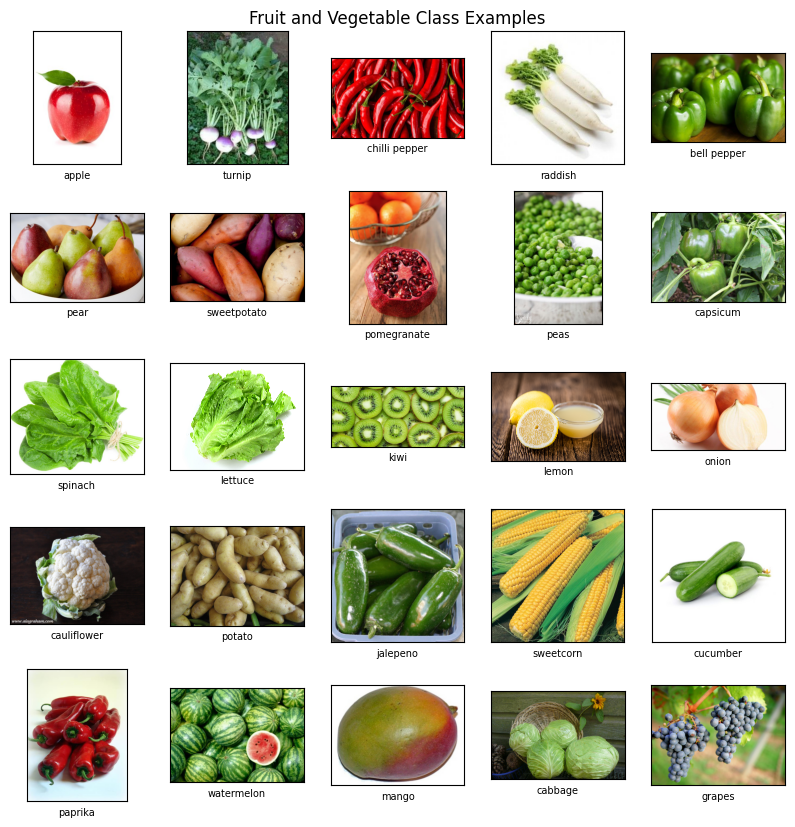

In [19]:
# https://matplotlib.org/stable/tutorials/images.html

# subdirs... which are classes
class_names = os.listdir(train_dir)

plt.figure(figsize=(10, 10))
plt.title('Fruit and Vegetable Class Examples')
plt.axis('off')

for i, class_name in enumerate(class_names[:25]):
    # path to each class
    class_dir = os.path.join(train_dir, class_name)

    if os.path.isdir(class_dir):
        # get images in each class dir
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('jpg', 'jpeg', 'png'))]
        
        # if class dir has contents
        if len(image_files) > 0:
            # open first image
            image_path = os.path.join(class_dir, image_files[0])
            image = Image.open(image_path)

            # add image to plot
            plt.subplot(5, 5, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(image)
            plt.xlabel(class_name, fontsize=7)

plt.show()

## Deep CNN Model

In [20]:
num_classes = 36

model = kb.Sequential([
    # data augmentation
    kb.layers.RandomFlip('horizontal', input_shape=(150, 150, 3)),
    kb.layers.RandomRotation(0.2),                                   
    kb.layers.RandomZoom(0.2),

    # max pooling
    kb.layers.MaxPooling2D((2, 2), padding='same'),

    # convolution, batch norm, max pooling
    kb.layers.Conv2D(32, (3, 3), activation='relu'),
    kb.layers.BatchNormalization(),              
    kb.layers.MaxPooling2D((2, 2)),

    # convolution, batch norm
    kb.layers.Conv2D(32, (3, 3), activation='relu'),
    kb.layers.BatchNormalization(),

    # convolution, batch norm
    kb.layers.Conv2D(64, (3, 3), activation='relu'),
    kb.layers.BatchNormalization(),

    # convolution, batch norm, max pooling
    kb.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    kb.layers.BatchNormalization(),
    kb.layers.MaxPooling2D((2, 2)),

    # convolution, batch norm
    kb.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    kb.layers.BatchNormalization(),

    kb.layers.Flatten(),
    kb.layers.Dense(128, activation='relu'),
    kb.layers.Dropout(0.5),
    kb.layers.Dense(num_classes, activation='softmax'),
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 150, 150, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 73, 73, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 73, 73, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,450,692 (16.98 MB)

 Trainable params: 4,449,924 (16.98 MB)

 Non-trainable params: 768 (3.00 KB)

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.0597 - loss: 4.1350 - val_accuracy: 0.0370 - val_loss: 3.8349
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.1209 - loss: 3.2798 - val_accuracy: 0.0399 - val_loss: 4.3327
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.1597 - loss: 3.0962 - val_accuracy: 0.0969 - val_loss: 3.5020
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.2076 - loss: 2.9035 - val_accuracy: 0.1852 - val_loss: 3.3560
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.2457 - loss: 2.7861 - val_accuracy: 0.2849 - val_loss: 2.6059
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.2586 - loss: 2.7480 - val_accuracy: 0.4729 - val_loss: 1.9233
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.2788 - loss: 2.6490 - val_accuracy: 0.5413 - val_loss: 1.6625
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.3000 - loss: 2

In [22]:
cnn_train_loss, cnn_train_accuracy = model.evaluate(train_ds)

print(f"Train Loss: {cnn_train_loss}")
print(f"Train Accuracy: {cnn_train_accuracy}")

cnn_test_loss, cnn_test_accuracy = model.evaluate(test_ds)

print(f"Test Loss: {cnn_test_loss}")
print(f"Test Accuracy: {cnn_test_accuracy}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.7614 - loss: 0.7769
Train Loss: 0.806296706199646
Train Accuracy: 0.7539382576942444
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8464 - loss: 0.5655
Test Loss: 0.5589285492897034
Test Accuracy: 0.8419618606567383


## Transfer Learning Model

Reload dataset

In [23]:
transfer_train_ds = kb.utils.image_dataset_from_directory(
  train_dir,
  seed=123, 
  image_size= (image_width, image_height),
  batch_size=batch_size,
  label_mode='int')

transfer_val_ds = kb.utils.image_dataset_from_directory(
  val_dir, 
  seed=123, 
  image_size= (image_width, image_height), 
  batch_size=batch_size,
  label_mode='int')

transfer_test_ds = kb.utils.image_dataset_from_directory(
  test_dir, 
  seed=123, 
  image_size= (image_width, image_height), 
  batch_size=batch_size,
  label_mode='int')

Found 3174 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Found 367 files belonging to 36 classes.


Load model and remove top

In [24]:
vgg_conv = kb.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (150,150,3)
)

vgg_conv.trainable = False
vgg_conv.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Build FF Layers

In [25]:
inputs = kb.Input(shape=(150, 150, 3))
x = kb.applications.vgg16.preprocess_input(inputs)
x = vgg_conv(x, training=False)
x = kb.layers.Flatten()(x)
x = kb.layers.Dense(512)(x)
# x = kb.layers.Dropout(0.2)(x)
outputs = kb.layers.Dense(num_classes, activation="softmax")(x)

transfer_model = kb.Model(inputs, outputs)

In [26]:
transfer_model.compile(loss='sparse_categorical_crossentropy', optimizer=kb.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
transfer_model.fit(transfer_train_ds, epochs = 5, validation_data = transfer_val_ds)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.2932 - loss: 27.2935 - val_accuracy: 0.8262 - val_loss: 2.5377
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8161 - loss: 3.2717 - val_accuracy: 0.9316 - val_loss: 2.1109
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9137 - loss: 1.4828 - val_accuracy: 0.9544 - val_loss: 1.2329
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9473 - loss: 1.0108 - val_accuracy: 0.9516 - val_loss: 2.0889
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9498 - loss: 1.0980 - val_accuracy: 0.9573 - val_loss: 1.4141


In [27]:
transfer_train_loss, transfer_train_accuracy = transfer_model.evaluate(transfer_train_ds)

print(f"Train Loss: {transfer_train_loss}")
print(f"Train Accuracy: {transfer_train_accuracy}")

transfer_test_loss, transfer_test_accuracy = transfer_model.evaluate(transfer_test_ds)

print(f"Test Loss: {transfer_test_loss}")
print(f"Test Accuracy: {transfer_test_accuracy}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9710 - loss: 0.5791
Train Loss: 0.44697126746177673
Train Accuracy: 0.9773156642913818
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 965ms/step - accuracy: 0.9463 - loss: 1.4817
Test Loss: 1.3524836301803589
Test Accuracy: 0.9591280817985535
